# Numerical Optimization

This notebook uses the [Optim.jl](https://github.com/JuliaNLSolvers/Optim.jl) package which has general purpose routines for optimization. (Other packages that do similar things are [Optimization.jl](https://github.com/SciML/Optimization.jl), [NLopt.jl](https://github.com/JuliaOpt/NLopt.jl) and [JuMP.jl](https://github.com/JuliaOpt/JuMP.jl))

The optimization problems are (for pedagogical reasons) the same as in the other notebook about optimization. This means that the solutions should be very similar and that the contour plots in the other notebook can be used as references.

However, the current notebook is focused on methods for solving general optimization problems. In contrast, the other notebook focuses on linear-quadratic problems (mean-variance, least squares, etc), where there are faster algorithms. 

## Load Packages and Extra Functions

In [1]:
using Printf, Optim

include("jlFiles/printmat.jl");

In [2]:
using Plots

gr(size=(480,320))
default(fmt = :png)

# Optimization with One Choice Variable

Running 
```
Sol = optimize(x->fn1(x,0.5),a,b)
```
finds the `x` value (in the interval `[a,b]`) that *minimizes* `fn1(x,0.5)`. The `x->fn1(x,0.5)` syntax makes this a function of `x` only, which is what the `optimize() function` wants.

The output (`Sol`) contains a lot of information.

In [3]:
function fn1(x,c)                    #notice: the function has two arguments
  value = 2*(x - 1.1)^2 - c
  return value
end

fn1 (generic function with 1 method)

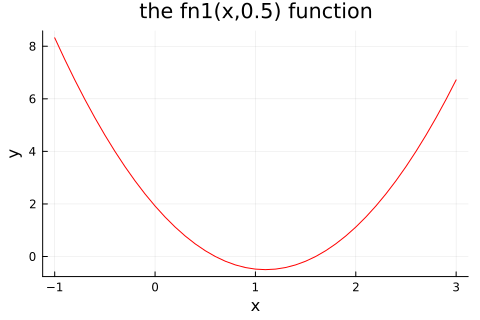

In [4]:
x = -1:0.1:3

p1 = plot( x,fn1.(x,0.5),                 #plotting the function can help identify
           linecolor = :red,              #starting points and possible issues
           linewidth = 1,
           legend = nothing,
           title = "the fn1(x,0.5) function",
           xlabel = "x",
           ylabel = "y" )
display(p1)

In [5]:
Sol = optimize(x->fn1(x,0.5),-2.0,3.0)
println(Sol)

printblue("\nThe minimum is at: ", Optim.minimizer(Sol))     #the optimal x value
printblue("Compare with the plot above")

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [-2.000000, 3.000000]
 * Minimizer: 1.100000e+00
 * Minimum: -5.000000e-01
 * Iterations: 5
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 6

The minimum is at: 1.1
Compare with the plot above


## One Choice Variable: Supplying a Starting Guess Instead (extra)

If you prefer to give a starting guess `c` instead of an interval, then supply it as as a vector `[c]`. The solution is then also a vector (with one element.)

In [6]:
Solb = optimize(x->fn1(x[],0.5),[0.1])

printlnPs("The minimum is at: ",Optim.minimizer(Solb))

The minimum is at:      1.100


# Several Choice Variables: Unconstrained Optimization

In the example below, we choose $(x,y)$ so as to minimize the fairly simple objective function

$
(x-2)^2 + (4y+3)^2,  
$

without any constraints. The solution should be $(x,y)=(2,-3/4)$.

In [7]:
function fn2(θ)
    (x,y) = (θ[1],θ[2])          #unpack the choice variables and get nicer names
     L    = (x-2)^2 + (4*y+3)^2
    return L
end

fn2 (generic function with 1 method)

In [8]:
θ₀ = [4.0,-0.5]               #starting guess

Sol = optimize(fn2,θ₀)        #use θ->lossfn(θ,other arguments) if there are
                              #additional (non-choice) function arguments
printlnPs("minimum at (x,y)= ",Optim.minimizer(Sol))

minimum at (x,y)=      2.000    -0.750


# Several Choice Variables: Bounds on the Solutions

The next few cells discuss how to impose bounds on the solution.

In the example below, we impose $2.75 \leq x$ (a lower bound) and $y \leq -0.3$ (an upper bound). We will see that only one of these restrictions binds.

In [9]:
lower_θ = [2.75, -Inf]
upper_θ = [Inf, -0.3]

Sol = optimize(fn2,lower_θ,upper_θ,θ₀)
printlnPs("The optimum is at (x,y) = ",Optim.minimizer(Sol))

The optimum is at (x,y) =      2.750    -0.750


# Several Choice Variables: Equality Restrictions (extra)

We now impose the constraint that $x+2y-3=0$ (that is, $y=1.5-0.5x$) The `Optim.jl` package can handle both equality and inequality constraints, but the syntax is a bit more involved than in the earlier examples. The remarks below discuss this. (Clearly, we could handle this single linear equality constraint by rewriting the objecive function instead, so consider this as just a simple illustration.) The solution should be at $(x,y)=(4,-0.5)$

### Remarks on the Code

1. `TwiceDifferentiable(fn2,θ₀)` and `TwiceDifferentiableConstraints(EqConstrfun!,lower_θ,upper_θ,lower_c,upper_c)` tell the `optimize()` function that the objective function and constraint are differentiable (twice).

2. The function for the constraint (`EqConstrfun!(c,θ)`) takes two inputs: `c` will be filled (by `optimize()`) with the calculations in the function and `θ` is the vector of choice variables.

3. `lower_θ` and `upper_θ` are (vectors of) bounds on the choice variables. With no bounds, use `[-Inf,-Inf]` and `[Inf,Inf]`.

4. `lower_c` and `upper_c` are (vectors of) bounds on the output from the constraint function. With a single equality constraint, use `[0.0]` for both.

In [10]:
function EqConstrfun!(c,θ)       #a function for a constraint
    (x,y) = (θ[1],θ[2])          #c is an array where results are written to
    c[1]  = x + 2*y - 3          #update the input c
    return c
end

lower_θ = [-Inf,-Inf]                 #effectively no bounds on the parameters, but needed
upper_θ = [Inf,  Inf]
lower_c = [0.0]                       #c from EqConstrfun! should be lower_c <= c <= upper_c
upper_c = [0.0]

df  = TwiceDifferentiable(fn2,θ₀)       #informing about the differentiability of the problem
dfc = TwiceDifferentiableConstraints(EqConstrfun!,lower_θ,upper_θ,lower_c,upper_c)
Sol = optimize(df,dfc,θ₀,IPNewton())
println("Constrained, x+2y-3=0")
printlnPs(Optim.minimizer(Sol))

Constrained, x+2y-3=0
     4.000    -0.500


# Optimization with Inequality Constraints (extra)

We now impose the non-linear constraint that $y \le -(x-4)^2$, that is, $y + (x-4)^2 \le 0$.

This is very similar to the linear constraint above, except that we need a new constraint function and that `lower_c = [-Inf]` and `upper_c = [0.0]`.

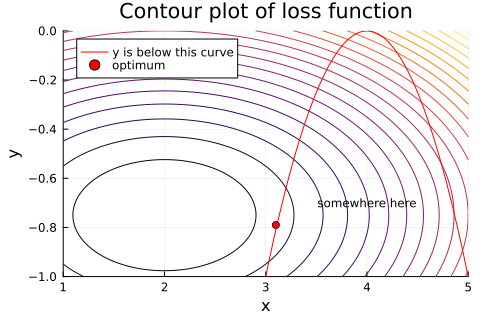

In [11]:
nx = 2*41
ny = 2*61
x = range(1,5,length=nx)
y = range(-1,0,length=ny)

loss2d = fill(NaN,(nx,ny))      #matrix with loss fn values
for i in 1:nx, j in 1:ny
    loss2d[i,j] = fn2([x[i];y[j]])
end

yRestriction = -(x.-4).^2               #y should be less than this

p1 = contour( x,y,loss2d',
              legend = false,
              levels = 21,
              title = "Contour plot of loss function",
              xlabel = "x",
              ylabel = "y",
              xlims = (1,5),
              ylims = (-1,0),
              annotation = (4.0,-0.7,text("somewhere here",8)) )
plot!(x,yRestriction,linecolor=:red,linewidth=1,label="y is below this curve")
scatter!([3.1],[-0.79],markercolor=:red,label="optimum",legend=:topleft)
display(p1)

In [12]:
function IneqConstrfun!(c,θ)            #another restriction
    (x,y) = (θ[1],θ[2])
    c[1]  = y + (x-4)^2                 #lower_c <= c[1] <= upper_c
  return c
end

lower_θ = [-Inf,-Inf]                   #effectively no bounds on the parameters
upper_θ = [Inf,Inf]
lower_c = [-Inf]                        # -Inf <= c <= 0.0
upper_c = [0.0]

df  = TwiceDifferentiable(fn2,θ₀)       
dfc = TwiceDifferentiableConstraints(IneqConstrfun!,lower_θ,upper_θ,lower_c,upper_c)
Sol = optimize(df,dfc,θ₀,IPNewton())
println("Constrained, y + (x-4)^2 <= 0")
printlnPs(Optim.minimizer(Sol))

Constrained, y + (x-4)^2 <= 0
     3.112    -0.789


# Several Choice Variables:  Supplying the Gradient (extra)

Supplying a function for calculating the derivatives improves speed and accuracy. See below for an example.

In [13]:
function g2!(G,θ)                        #derivatives of fn2 wrt. θ[1] and θ[2]
    (x,y) = (θ[1],θ[2])
    G[:] = [2*(x-2), 2*4*(4*y+3)]        #fills/updates an existing vector
    return G
end

Sol3 = optimize(fn2,g2!,[1.0,-0.5])
println(Sol3)
printblue("Probably faster than the solution above")
printblue("Minimum at: ",round.(Optim.minimizer(Sol3),digits=3))

 * Status: success

 * Candidate solution
    Final objective value:     9.860761e-30

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 9.34e-01 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.67e-01 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.75e-01 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.88e+28 ≰ 0.0e+00
    |g(x)|                 = 2.49e-14 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    2
    f(x) calls:    7
    ∇f(x) calls:   7

Probably faster than the solution above
Minimum at: [2.0, -0.75]
